# SplicingIndex figure

This notebook creates a single figure, **splicingIndex.pdf**, a plot showing the number of AS events per 1000 exons for each chromosome.

In [1]:
start_time <- Sys.time()
suppressMessages({
    options(warn = 1)
    library(dplyr)
    library(devtools)
    library(ggplot2)
    library(rtracklayer)
    library(GenomeInfoDb)
    library(GenomeInfoDbData)
})

### 1. read in gene_as.tsv data containing all significant alternative splicing events

In [2]:
filename <- "../data/gene_as.tsv"
gene_as <- read.table(filename, header=TRUE, sep="\t", skipNul=FALSE, stringsAsFactors = FALSE)
head(gene_as,2)

,GeneJunction,ASE,ASE_IDX,Tissue,counts,Display,GeneSymbol,GeneID,chr,logFC,AveExpr,t,PValue,AdjPVal,B
,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,SCO1-8452,A3SS,8452,adrenal_gland,1,Adrenal gland,SCO1,ENSG00000133028.12,chr17,0.7715834,5.028635,4.906848,1.533202e-06,8.170436e-03,0.8561371
2,XIST-2252,A3SS,2252,artery_coronary,1,Coronary artery,XIST,ENSG00000229807.11,chrX,-2.1880965,4.327079,-10.329346,4.631685e-21,2.464057e-17,16.7535120


### 2 Count most frequent spliced chromosomes
To get an indication of which chromosome has the most frequent slicing event (regardless of type)
We create an index based upon the number of exons per chromosome.

get the annotation file, at this writing, gencode.v30.annotation.gtf
The information as to the number of exons within the chromosome may be found there

In [3]:
if (!("gencode.v30.annotation.gtf.gz" %in% list.files("../data/"))) {
    message("downloading gencode v30 annotation\n")
    system("wget -O ../data/gencode.v30.annotation.gtf.gz ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_30/gencode.v30.annotation.gtf.gz")
    message("Done!\n")
    message("Unzipping compressed file gencode.v30.annotation.gtf.gz..")
    system("gunzip ../data/gencode.v30.annotation.gtf.gz", intern = TRUE)
    message("Done! gencode.v30.annotation.gtf can be found in ../data/")
}
gencode <- rtracklayer::import("../data/gencode.v30.annotation.gtf")

In [4]:
exons <- gencode[ gencode$type == "exon", ]
exons <- as.data.frame(exons)

#Obtain chromosomes we have splicing information for (recall we did not use chr Y in our analysis)
all_chr <- as.character(unique(gene_as$chr))
chr_counts <- rep(0, length(all_chr))


for (i in 1:length(all_chr)) {
  chr_counts[i] <- nrow(exons[exons$seqnames == all_chr[i], ])
}

exon_counts <- data.frame(chr = all_chr, counts = chr_counts)

# Count most frequent spliced chromosomes
res <- gene_as %>% group_by(chr) %>% count(chr) %>% arrange(desc(n)) %>% as.data.frame()
res$chr <- factor(res$chr, levels = res$chr)

idx <- match(res$chr, exon_counts$chr)

res$ExonCounts <- exon_counts$counts[idx]

res$Index <- (res$n / res$ExonCounts) * 1000

res_sorted <- res %>% arrange(desc(Index))
res_sorted$chr <- factor(res_sorted$chr, levels = res_sorted$chr)
glimpse(res_sorted)
message("res_sorted has ", length(res_sorted$chr), " chromosomes with data about events, exons, and the splicing index")

Rows: 23
Columns: 4
$ chr        <fct> chrX, chr16, chr22, chr19, chr17, chr1, chr20, chr10, chr8,…
$ n          <int> 68, 47, 22, 55, 56, 83, 19, 31, 25, 8, 41, 24, 35, 29, 22, …
$ ExonCounts <dbl> 40029, 61199, 28655, 74466, 78291, 118996, 28506, 47124, 45…
$ Index      <dbl> 1.6987684, 0.7679864, 0.7677543, 0.7385921, 0.7152802, 0.69…


res_sorted has 23 chromosomes with data about events, exons, and the splicing index



In [5]:
# Colors for uniformity
# Let's use the following colors for uniformity
darkblue <- "#3c5488"
red <- "#e64b35"
nearlyblack <- "#040C04"
purple <- "#790079"
orange = "#ff9900"

Saving 6.67 x 6.67 in image



Saved plot as ../pdf/splicingIndex.pdf



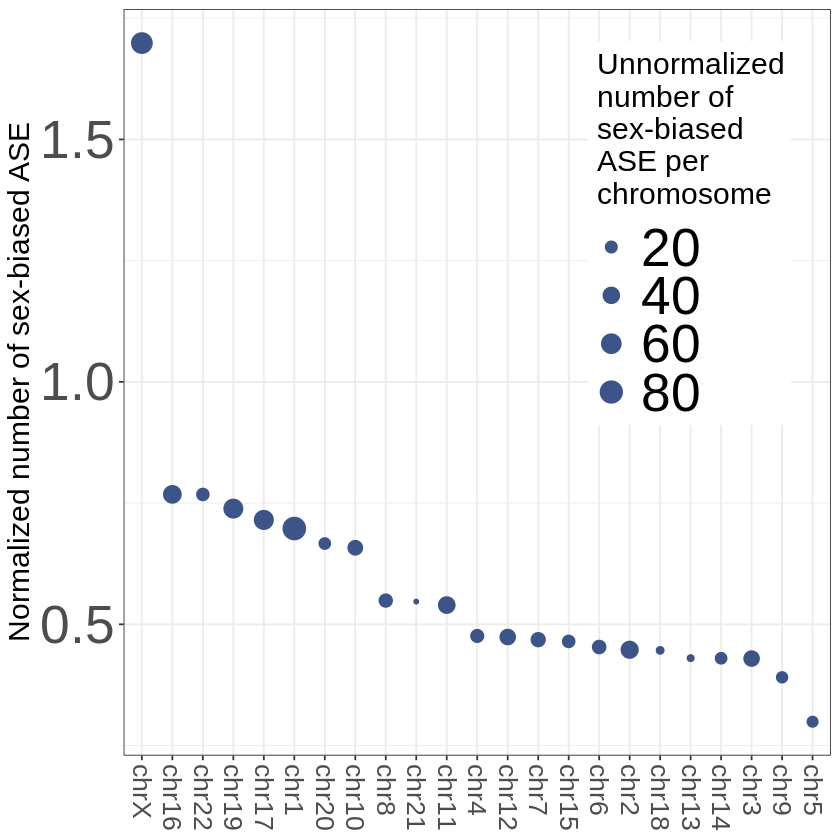

In [6]:
g2 <- ggplot(res_sorted, aes(x = chr, y = Index, size = n)) +
  geom_point(color = darkblue) +
  theme_bw() +
  theme(axis.text.x = element_text(size=16, angle = 270, hjust = 0.0, vjust = 0.5),
        axis.text.y = element_text(size=32),
        axis.title.x = element_blank(),
        axis.title.y = element_text(face="plain", colour="black", 
                                    size=18),
        legend.title=element_text(face="plain", colour="black", 
                                    size=18),
        legend.text = element_text(face="plain", colour="black", 
                                   size=32),
        legend.position = c(0.8, 0.7)) +
  scale_fill_viridis_c(aesthetics = c("colour", "fill"),
                       option = "plasma",
                       limits = c(1, 650)) +
  ylab(paste("Normalized number of sex-biased ASE")) +
  guides(size = guide_legend(title = "Unnormalized\nnumber of\nsex-biased\nASE per\nchromosome"))
ggsave("../pdf/splicingIndex.pdf",g2)
message("Saved plot as ../pdf/splicingIndex.pdf")
g2

### Appendix - Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### Appendix 1. Checksums with the sha256 algorithm

In [7]:
notebookid = "create_SplicingIndex_figure"

### Appendix 2. Libraries metadata

In [8]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../data/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../data/", notebookid, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../data/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../data/", notebookid ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../data/devtools_session_info.rds  ..



Done!




Saving `utils::sessionInfo()` objects in ../data/utils_session_info.rds  ..



Done!




 setting  value                       
 version  R version 4.1.0 (2021-05-18)
 os       Ubuntu 18.04.4 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2021-06-27                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
BiocGenerics,BiocGenerics,0.38.0,0.38.0,/opt/conda/envs/sbas/lib/R/library/BiocGenerics,/opt/conda/envs/sbas/lib/R/library/BiocGenerics,TRUE,FALSE,2021-05-19,Bioconductor,NA,/opt/conda/envs/sbas/lib/R/library
devtools,devtools,2.4.2,2.4.2,/opt/conda/envs/sbas/lib/R/library/devtools,/opt/conda/envs/sbas/lib/R/library/devtools,TRUE,FALSE,2021-06-07,CRAN (R 4.1.0),NA,/opt/conda/envs/sbas/lib/R/library
dplyr,dplyr,1.0.7,1.0.7,/opt/conda/envs/sbas/lib/R/library/dplyr,/opt/conda/envs/sbas/lib/R/library/dplyr,TRUE,FALSE,2021-06-18,CRAN (R 4.1.0),NA,/opt/conda/envs/sbas/lib/R/library
GenomeInfoDb,GenomeInfoDb,1.28.0,1.28.0,/opt/conda/envs/sbas/lib/R/library/GenomeInfoDb,/opt/conda/envs/sbas/lib/R/library/GenomeInfoDb,TRUE,FALSE,2021-05-19,Bioconductor,NA,/opt/conda/envs/sbas/lib/R/library
GenomeInfoDbData,GenomeInfoDbData,1.2.6,1.2.6,/opt/conda/envs/sbas/lib/R/library/GenomeInfoDbData,/opt/conda/envs/sbas/lib/R/library/GenomeInfoDbData,TRUE,FALSE,2021-06-26,Bioconductor,NA,/opt/conda/envs/sbas/lib/R/library
GenomicRanges,GenomicRanges,1.44.0,1.44.0,/opt/conda/envs/sbas/lib/R/library/GenomicRanges,/opt/conda/envs/sbas/lib/R/library/GenomicRanges,TRUE,FALSE,2021-05-19,Bioconductor,NA,/opt/conda/envs/sbas/lib/R/library
ggplot2,ggplot2,3.3.5,3.3.5,/opt/conda/envs/sbas/lib/R/library/ggplot2,/opt/conda/envs/sbas/lib/R/library/ggplot2,TRUE,FALSE,2021-06-25,CRAN (R 4.1.0),NA,/opt/conda/envs/sbas/lib/R/library
IRanges,IRanges,2.26.0,2.26.0,/opt/conda/envs/sbas/lib/R/library/IRanges,/opt/conda/envs/sbas/lib/R/library/IRanges,TRUE,FALSE,2021-05-19,Bioconductor,NA,/opt/conda/envs/sbas/lib/R/library
rtracklayer,rtracklayer,1.52.0,1.52.0,/opt/conda/envs/sbas/lib/R/library/rtracklayer,/opt/conda/envs/sbas/lib/R/library/rtracklayer,TRUE,FALSE,2021-05-19,Bioconductor,NA,/opt/conda/envs/sbas/lib/R/library


In [9]:
end_time <- Sys.time()
end_time - start_time

Time difference of 54.99931 secs